# Summary
In this part we again want to train a regressor to learn the CVF-logprobs from an INN, but let the regressor predict the logprobs from the INN´s latent. We again compare the pre-trained and the joint-training cases. We employ a new training scheme in which we first load the data in one go instead of on-the-fly during training, to speed up training.\
# Takeaway
The generated distribution of the regressor trained on the INN´s latents looks a lot better than the distribution of the regressor trained on the coordiantes.\
It looks as though the regressor can minimize the KL divergence with the INN´s distribution as much as necessary, so the jist lies in optimally training the INN.
# Accuracy
**MMD of INN: 1,9e-3**\
**KL: 1e-2** (looks a lot better than in ex3 though.)

In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from torch.utils.data import DataLoader, Dataset

import distributions as d
import evaluation as e
import models as m
import FrEIA.modules as Fm
import FrEIA.framework as Ff

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import itertools
import copy
import time


import optuna
from optuna.trial import TrialState

c:\Users\Fritz\anaconda3\envs\analyzing_invs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global parameters

In [2]:
n_dim = 2
device = "cpu"

# INN Training parameters

In [3]:
subnet_hidden_dim = 20
n_blocks = 32
inn_batchsize = 100
inn_epochs = 4000
inn_lr = 0.0002
subnet_hidden_layers = 2

# Train INN and visualize learnt distributions

In [4]:
inn = m.realNVP(n_dim, subnet_hidden_dim, n_blocks, subnet_hidden_layers=subnet_hidden_layers)
inn, inn_metrics, models = m.train_inn(inn, 
                                     batchsize=inn_batchsize, 
                                     epochs=inn_epochs, 
                                     lr=inn_lr)

100%|██████████| 4000/4000 [03:22<00:00, 19.80it/s]


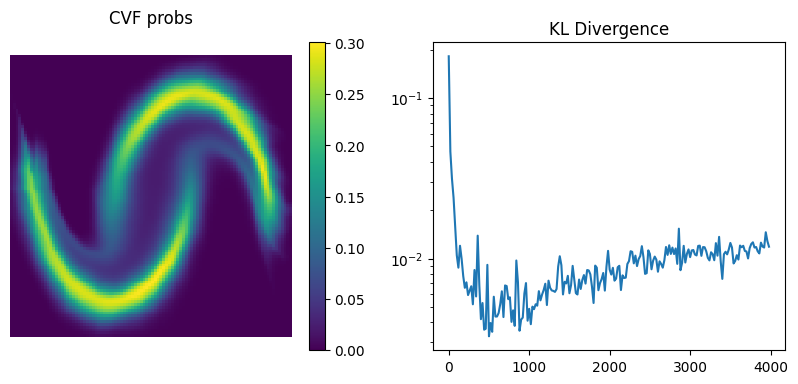

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs = axs.flatten()


e.contour_plot(inn, cvf=True, ax=axs[0])
axs[0].set_title("CVF probs")

axs[1].plot(inn_metrics["kl"][0], inn_metrics["kl"][1])
axs[1].set_title("KL Divergence")
axs[1].set_yscale("log")

# Contour plot of distributions during training

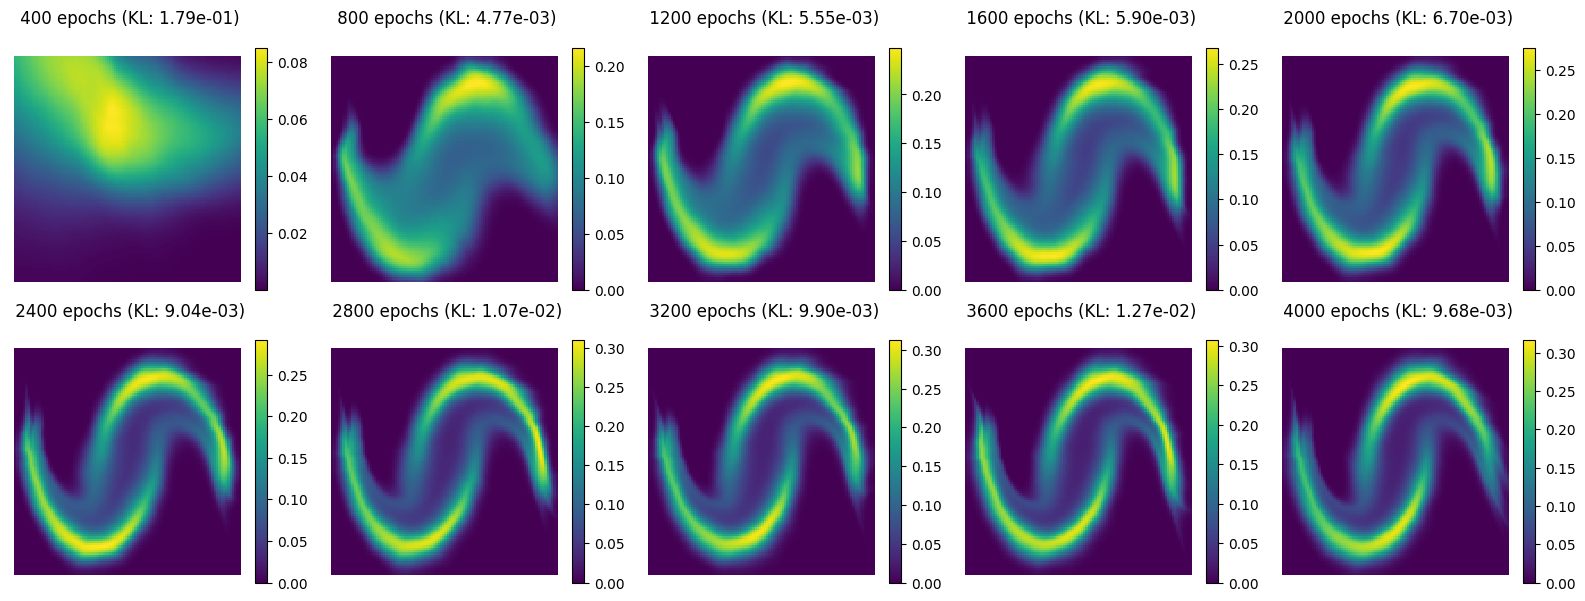

In [6]:
fig, axs = plt.subplots(2, 5, figsize=((16, 6)))
axs = axs.flatten()

for i in range(10):
    j = int(i * (inn_epochs / 200))
    epoch = int((i+1) * (inn_epochs / 10))
    if i == 10: j=-1
    e.contour_plot(models[j], cvf=True, ax=axs[i])
    axs[i].set_title(f" {epoch} epochs (KL: {e.kldiv(models[j], cvf=True).mean().item():.2e})")

    axs[i].axis("off")
plt.tight_layout()
plt.show()

# MMD test of samples

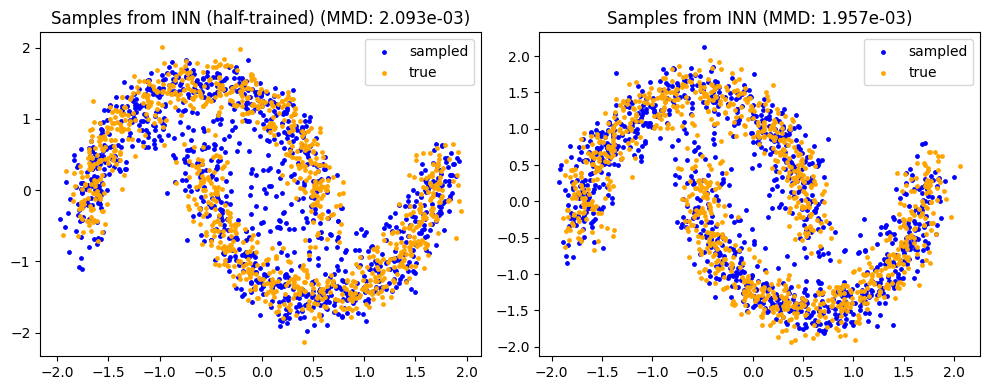

In [7]:
x, _ = make_moons(1000, noise=0.1)
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x = torch.Tensor(x_normalized)

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs = axs.flatten()

halftrained_inn = models[int(inn_epochs/40)]

e.plot_inn_samples(halftrained_inn, show_true=True, axs=axs[0])
samples_halftrained = halftrained_inn(torch.randn((1000, 2)), rev=True)
mmd_halftrained = e.mmd_inverse_multi_quadratic(x, samples_halftrained)
axs[0].set_title(f"Samples from INN (half-trained) (MMD: {mmd_halftrained:.3e})")

e.plot_inn_samples(inn, show_true=True, axs=axs[1])
samples_inn = inn(torch.randn((1000, 2)), rev=True)
mmd_inn = e.mmd_inverse_multi_quadratic(x, samples_inn)
axs[1].set_title(f"Samples from INN (MMD: {mmd_inn:.3e})")

plt.tight_layout()
plt.show()

# Functions for regressor training

In [8]:
def make_regressor(n_dim, hidden_dim, n_layers): 
    mle_layers = [nn.Linear(n_dim, hidden_dim), nn.ReLU()]
    for _ in range(n_layers):
        mle_layers.append(nn.Linear(hidden_dim, hidden_dim))
        mle_layers.append(nn.ReLU())
    mle_layers.append(nn.Linear(hidden_dim, 1))
    return nn.Sequential(*mle_layers)

def train_regressor(model, logprobs, z, lr=1e-4, epochs=500, 
                    batchsize=500, trial=None):
    optim = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    assert logprobs.shape[0] == z.shape[0]
    n_samples = z.shape[0]
    n_batches = n_samples // batchsize
    
    kld_history = []
    metrics = {}
    model_snapshots = []

    for epoch in tqdm.tqdm(range(epochs)):
        indices = torch.autograd.Variable(torch.randperm(n_samples), requires_grad=False)
        shuffled_z = torch.autograd.Variable(z[indices], requires_grad=False)
        shuffled_logprobs = torch.autograd.Variable(logprobs[indices], requires_grad=False)
        
        for i in range(n_batches):
            optim.zero_grad()        
            
            pred = model(shuffled_z[i*batchsize:(i+1)*batchsize,:])
            pred = torch.squeeze(pred)
            kld_loss = torch.mean(e.generalized_kl(pred, shuffled_logprobs[i*batchsize:(i+1)*batchsize]))
            
            kld_loss.backward()
                        
            optim.step()
            
            kld_history.append(kld_loss.item())
        
        if epoch%(epochs/10): model_snapshots.append(copy.deepcopy(model))
        
        if trial is not None: trial.report(kld_loss.item(), epoch)        
    metrics["kld_loss"] = kld_history
    return model, metrics, model_snapshots

# Parameters for regressor training

In [9]:
regressor_hidden_dim = 275
n_layers = 10
n_samples = 100000
regressor_batchsize = 200
regressor_lr = 0.0001
regressor_epochs = 3

# Prepare data (on-the-fly generation too expensive)

In [10]:
x, _ = make_moons(n_samples, noise=0.1)
x = torch.Tensor(x)
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x = torch.Tensor(x_normalized)
print(x.shape)

torch.Size([100000, 2])


In [11]:
logprobs = []
z = []
n_batches = 50
index = int(n_samples / n_batches)
for i in tqdm.tqdm(range(n_batches)):
    batch = x[i*index:(i+1)*index,:]
    logprobs.append(inn.logprob(batch))
    z.append(inn(batch)[0])
    time.sleep(.2)
logprobs = torch.cat(logprobs)
z = torch.cat(z, dim=0)

100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


# Train regressor to predict CVF logprobs from INN´s latents

In [12]:
regressor = make_regressor(n_dim, regressor_hidden_dim, n_layers)
regressor, metrics, models = train_regressor(regressor, 
                                    z=z,
                                    logprobs=logprobs, 
                                    epochs=regressor_epochs, 
                                    batchsize=regressor_batchsize, 
                                    lr=regressor_lr)

100%|██████████| 3/3 [01:04<00:00, 21.52s/it]


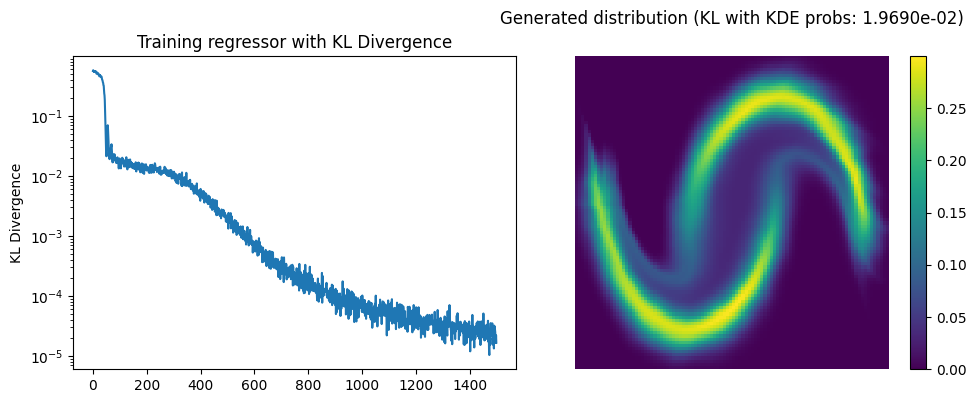

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

axs[0].plot(metrics["kld_loss"])
axs[0].set_ylabel("KL Divergence")
axs[0].set_yscale("log")
axs[0].set_title("Training regressor with KL Divergence")

e.contour_plot(regressor, axs[1], encoder=inn)
axs[1].set_title(f"Generated distribution (KL with KDE probs: {e.kldiv(regressor).mean().item():.4e})")

plt.tight_layout()
plt.show()

# Contour plots of distribution during training

In [17]:
print(len(models))

2


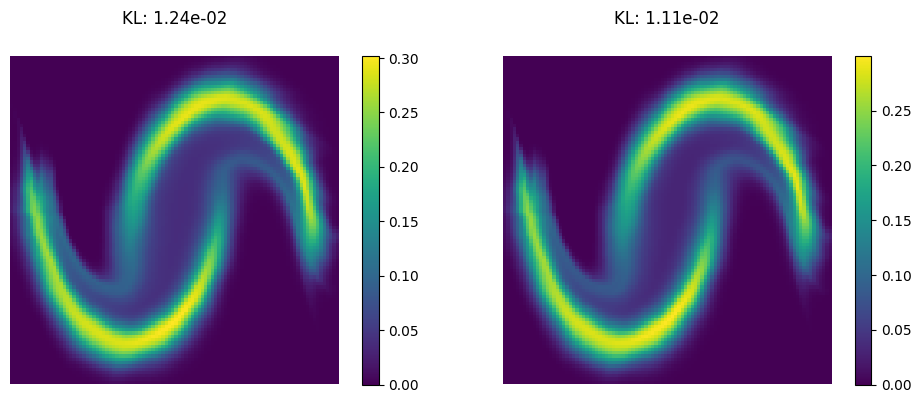

In [19]:
fig, axs = plt.subplots(1,2, figsize=((10, 4)))
axs = axs.flatten()

for i in range(2):
    e.contour_plot(models[i], ax=axs[i], encoder=inn)
    axs[i].set_title(f"KL: {e.kldiv(models[i], encoder=inn).mean().item():.2e}")

    axs[i].axis("off")
plt.tight_layout()
plt.show()